In [6]:
### BIO index clustering - python-only pipeline



In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [8]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm
import pipvis as vp
from importlib import reload

import sys
sys.path.append('./extraction_scripts')
import map_fxn as mf
reload(vp)


<module 'pipvis' from '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/pipvis.py'>

# this bit is clustering and doesn't need rerunning

## masking edges

In [9]:
bath = '/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc'
grid = mf.import_bathy(bath)
fmask = (grid.fmask[0,0,:,:]) 

stn_x, stn_y = mf.make_stns(10)
d_stn_x, d_stn_y = mf.filter_stn_in_domain(stn_x,stn_y,fmask)

d_stn_xar0 = np.array(d_stn_x)
d_stn_yar0 = np.array(d_stn_y)

edge = np.where((d_stn_xar0<=10) | (d_stn_yar0>=888))
np.squeeze(edge)
np.shape(edge)
edgear = np.array(edge)
edgear = edgear[0]
print(edge)
d_stn_xar =np.delete(d_stn_xar0,edge)
d_stn_yar = np.delete(d_stn_yar0,edge)
print(np.size(d_stn_xar))


    

(array([ 0,  1,  2,  3,  4,  5,  6,  7, 41]),)
571


In [10]:
## areas of stations

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
ydir = w['e1t'][0,:,:]
xdir = w['e2t'][0,:,:]
aos = ydir*xdir
print(aos[250,250])

stn_areas = np.zeros(580)
for i in range(0,580):
    t_x = d_stn_xar0[i]
    t_y = d_stn_yar0[i]
    stn_areas[i] = aos[t_y,t_x]

222393.81673895908



#### agglomerate signals extracted and save as .pkl, for year in 2013-2016

In [11]:
# do this for years 2013  to 2016
years = ['2013','2014','2015','2016']

for year in years:
    if year == '2016':
        noday = 366
    if year != '2016':
        noday = 365
        
    print(year)
    basedir = '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/NC_HINDCAST/'


    varfolder = 'BIO_TS'
    tname = './pkls/bio_datamat_'+year+'.pkl'
    
    signalmat = np.zeros([np.size(d_stn_xar),noday*3])
    count = 0 
    for i in range(0,580):
        
        if i not in edgear:
                #stn_360_sp10.nc
            pattern  = f'stn_{i}_sp10.nc'
            
            tdat = nc.Dataset(basedir+year +'/'+ varfolder +'/'+pattern)
           # print(tdat)
            signalmat[count,0:noday] = tdat['PHY'][:]/stn_areas[i]
            
            signalmat[count,(noday):(noday*2)] = tdat['PHY2'][:]/stn_areas[i]
            signalmat[count,noday*2:noday*3] = tdat['MYRI'][:]/stn_areas[i]
            count = count+1

    pickle.dump(signalmat, open(tname, 'wb'))


2013
2014
2015
2016


## open the resulting signalmats, cluster from 2-N (N=100) clusters, save linkage matrix and cluster matrices, visualise dendrograms

In [12]:
for year in years:
    print(year)
    signalmat = pickle.load(open('./pkls/bio_datamat_'+year+'.pkl', 'rb'))

    Z = linkage(signalmat, 'ward')
    pickle.dump(Z, open('./pkls/bio_linkmat_'+year+'.pkl', 'wb'))
    
    clustermat = np.zeros([100,np.size(d_stn_xar)])                           
    for k in range(0,100): 
        clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')
    pickle.dump(clustermat, open('./pkls/bio_clustmat_'+year+'.pkl', 'wb'))

2013
2014
2015
2016


## this bit is plotting 

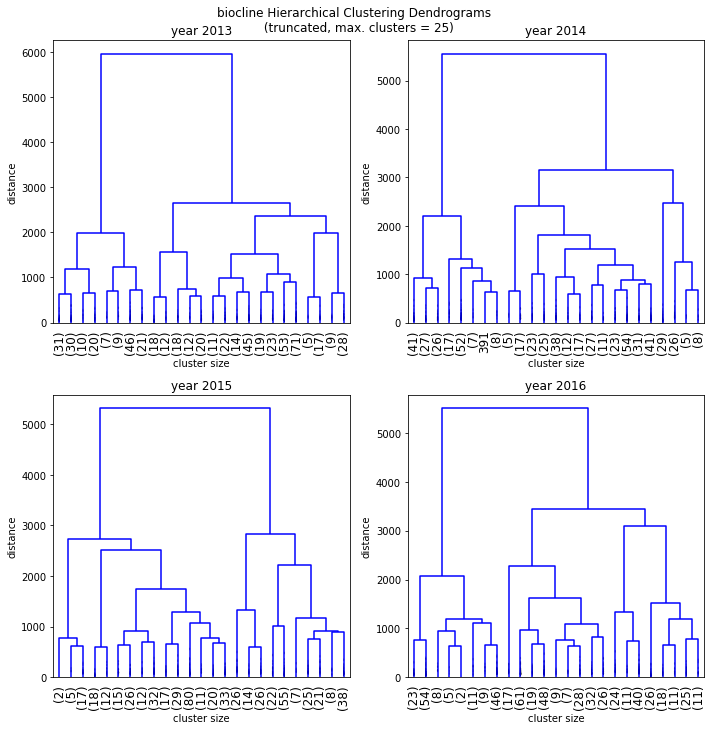

In [13]:
fact = 1
ms = 4
markersize = 10
legfontsize = 8

fig = plt.figure(figsize=(10*fact, 10*fact))

#####bio
ax1 = plt.subplot2grid((2,2),(0,0))
Z = pickle.load(open('./pkls/bio_linkmat_2013.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(0,1))
Z = pickle.load(open('./pkls/bio_linkmat_2014.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,0))
Z = pickle.load(open('./pkls/bio_linkmat_2015.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,1))
Z = pickle.load(open('./pkls/bio_linkmat_2016.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')

plt.suptitle('biocline Hierarchical Clustering Dendrograms \n (truncated, max. clusters = 25)', y = 1.01)
plt.tight_layout()
plt.show()


#### 'objective' measures of clustering are sometimes hard to defend

##### one way to circumvent this obvious problem is to look manually at the visual clusters provided


## 2013

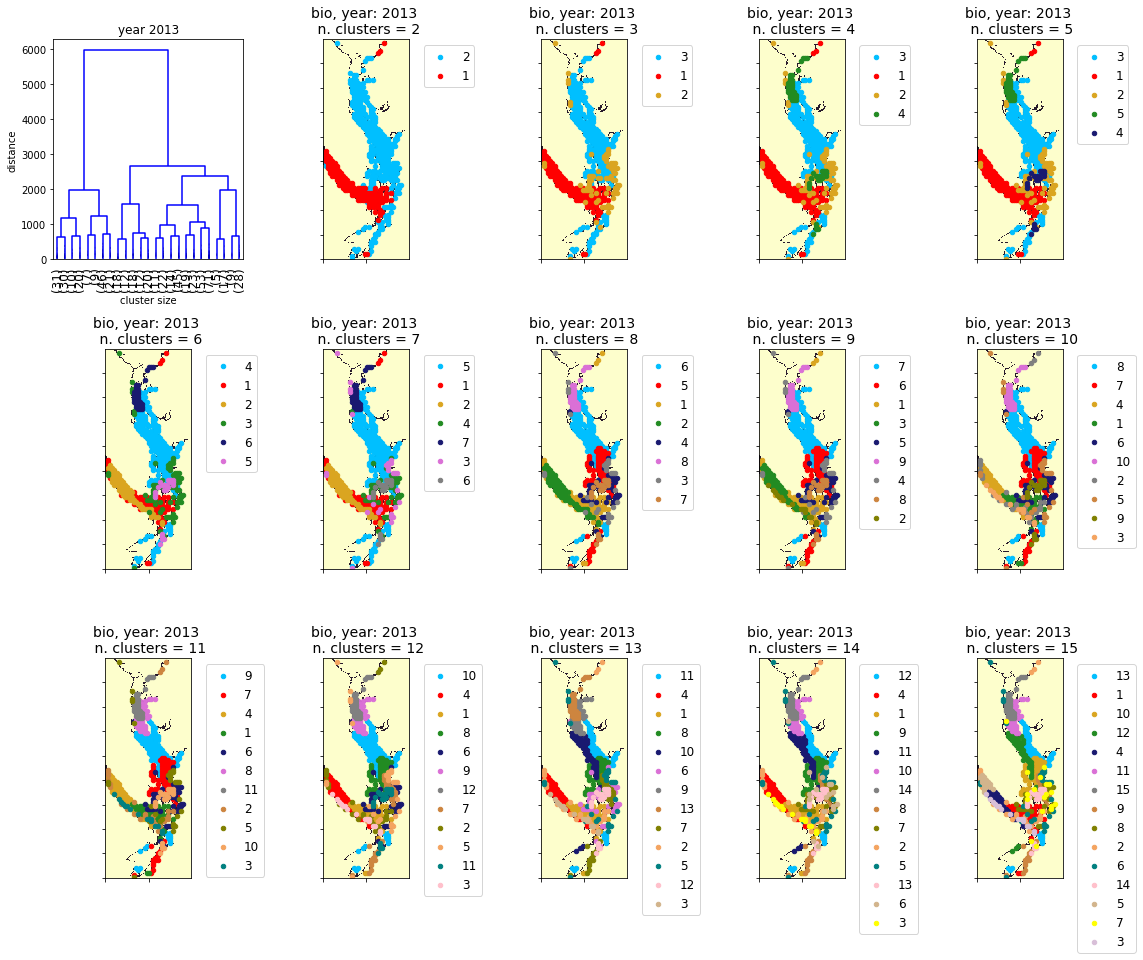

In [14]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/bio_linkmat_2013.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2013','bio',2)
vp.clusters(axs[0,2],'2013','bio',3)
vp.clusters(axs[0,3],'2013','bio',4)
vp.clusters(axs[0,4],'2013','bio',5)

vp.clusters(axs[1,0],'2013','bio',6)
vp.clusters(axs[1,1],'2013','bio',7)
vp.clusters(axs[1,2],'2013','bio',8)
vp.clusters(axs[1,3],'2013','bio',9)
vp.clusters(axs[1,4],'2013','bio',10)

vp.clusters(axs[2,0],'2013','bio',11)
vp.clusters(axs[2,1],'2013','bio',12)
vp.clusters(axs[2,2],'2013','bio',13)
vp.clusters(axs[2,3],'2013','bio',14)
vp.clusters(axs[2,4],'2013','bio',15)

plt.tight_layout()



## 2014

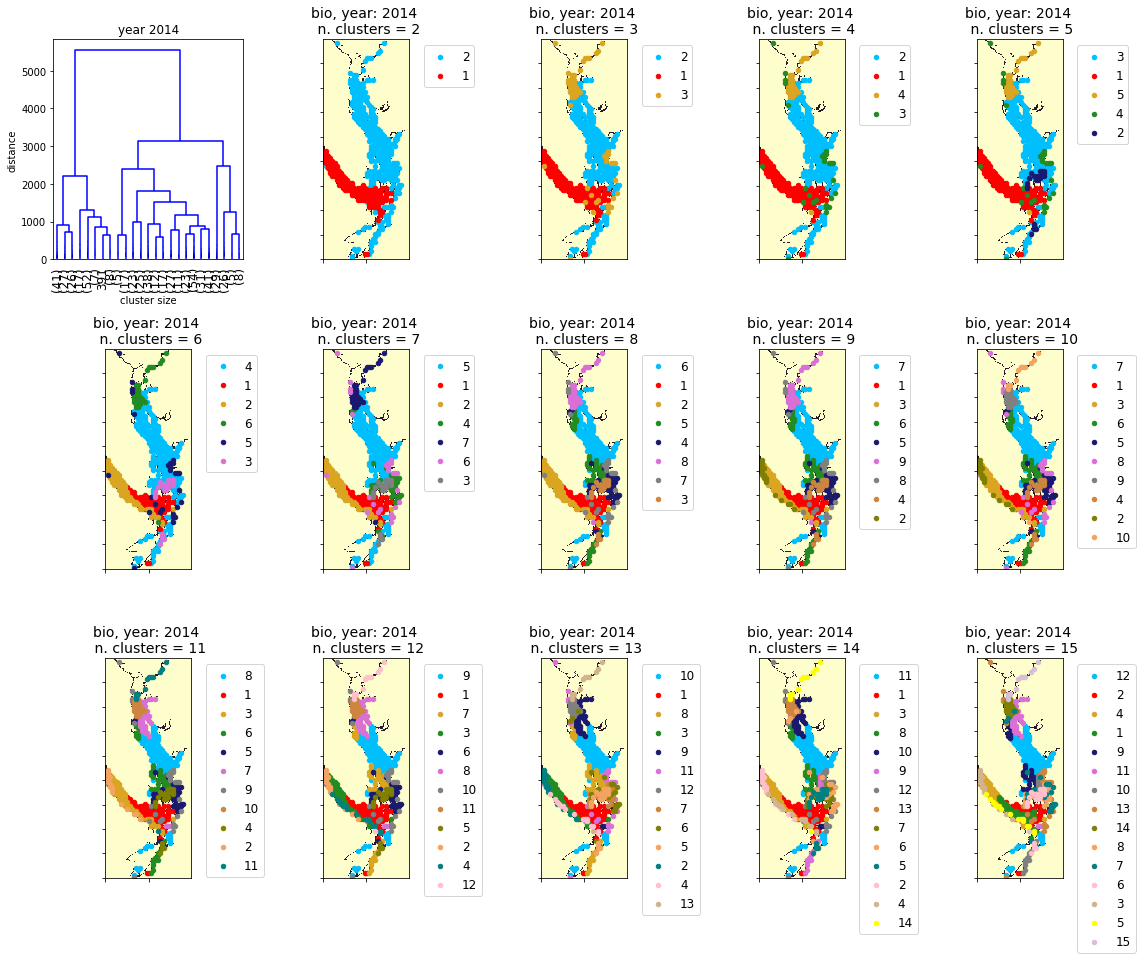

In [15]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/bio_linkmat_2014.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2014','bio',2)
vp.clusters(axs[0,2],'2014','bio',3)
vp.clusters(axs[0,3],'2014','bio',4)
vp.clusters(axs[0,4],'2014','bio',5)

vp.clusters(axs[1,0],'2014','bio',6)
vp.clusters(axs[1,1],'2014','bio',7)
vp.clusters(axs[1,2],'2014','bio',8)
vp.clusters(axs[1,3],'2014','bio',9)
vp.clusters(axs[1,4],'2014','bio',10)

vp.clusters(axs[2,0],'2014','bio',11)
vp.clusters(axs[2,1],'2014','bio',12)
vp.clusters(axs[2,2],'2014','bio',13)
vp.clusters(axs[2,3],'2014','bio',14)
vp.clusters(axs[2,4],'2014','bio',15)

plt.tight_layout()



## 2015 

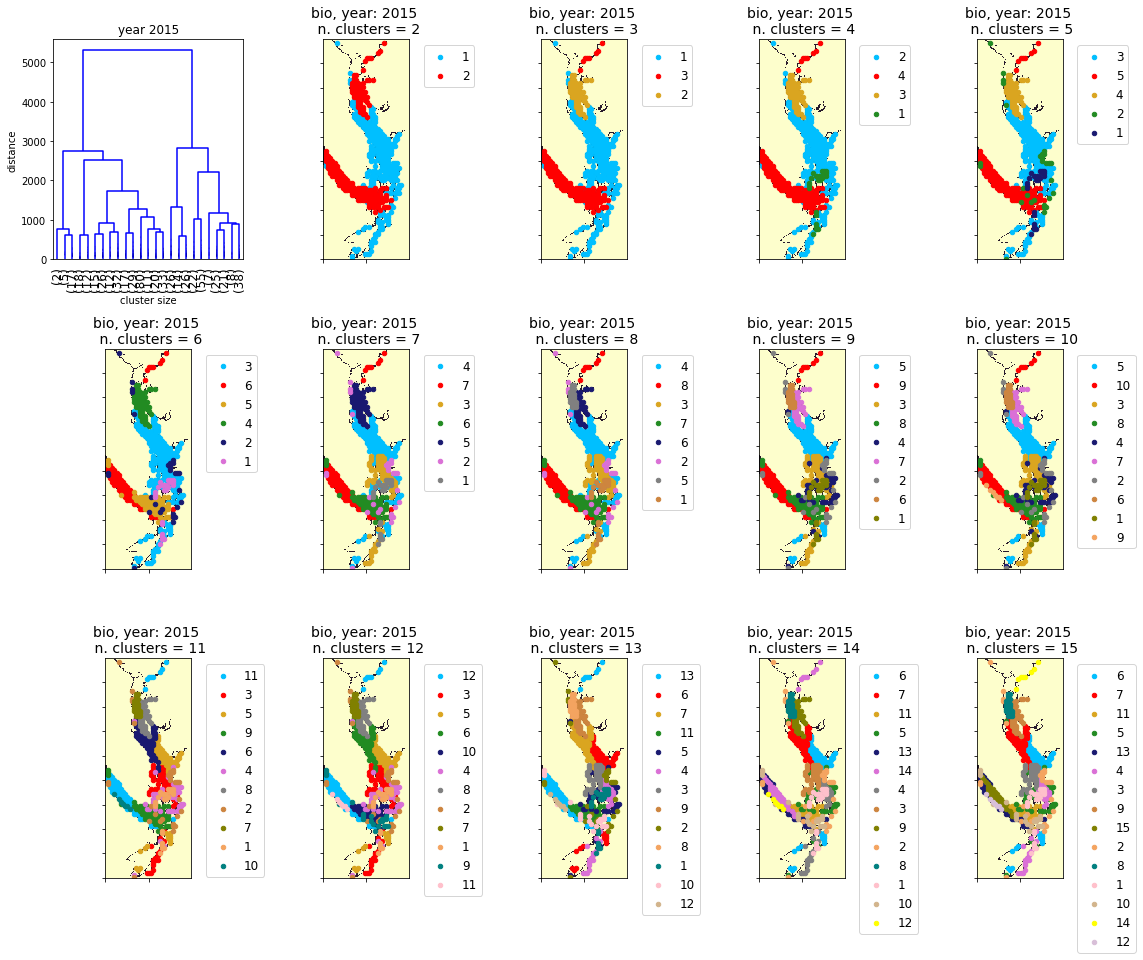

In [16]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/bio_linkmat_2015.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2015','bio',2)
vp.clusters(axs[0,2],'2015','bio',3)
vp.clusters(axs[0,3],'2015','bio',4)
vp.clusters(axs[0,4],'2015','bio',5)

vp.clusters(axs[1,0],'2015','bio',6)
vp.clusters(axs[1,1],'2015','bio',7)
vp.clusters(axs[1,2],'2015','bio',8)
vp.clusters(axs[1,3],'2015','bio',9)
vp.clusters(axs[1,4],'2015','bio',10)

vp.clusters(axs[2,0],'2015','bio',11)
vp.clusters(axs[2,1],'2015','bio',12)
vp.clusters(axs[2,2],'2015','bio',13)
vp.clusters(axs[2,3],'2015','bio',14)
vp.clusters(axs[2,4],'2015','bio',15)

plt.tight_layout()



## 2016

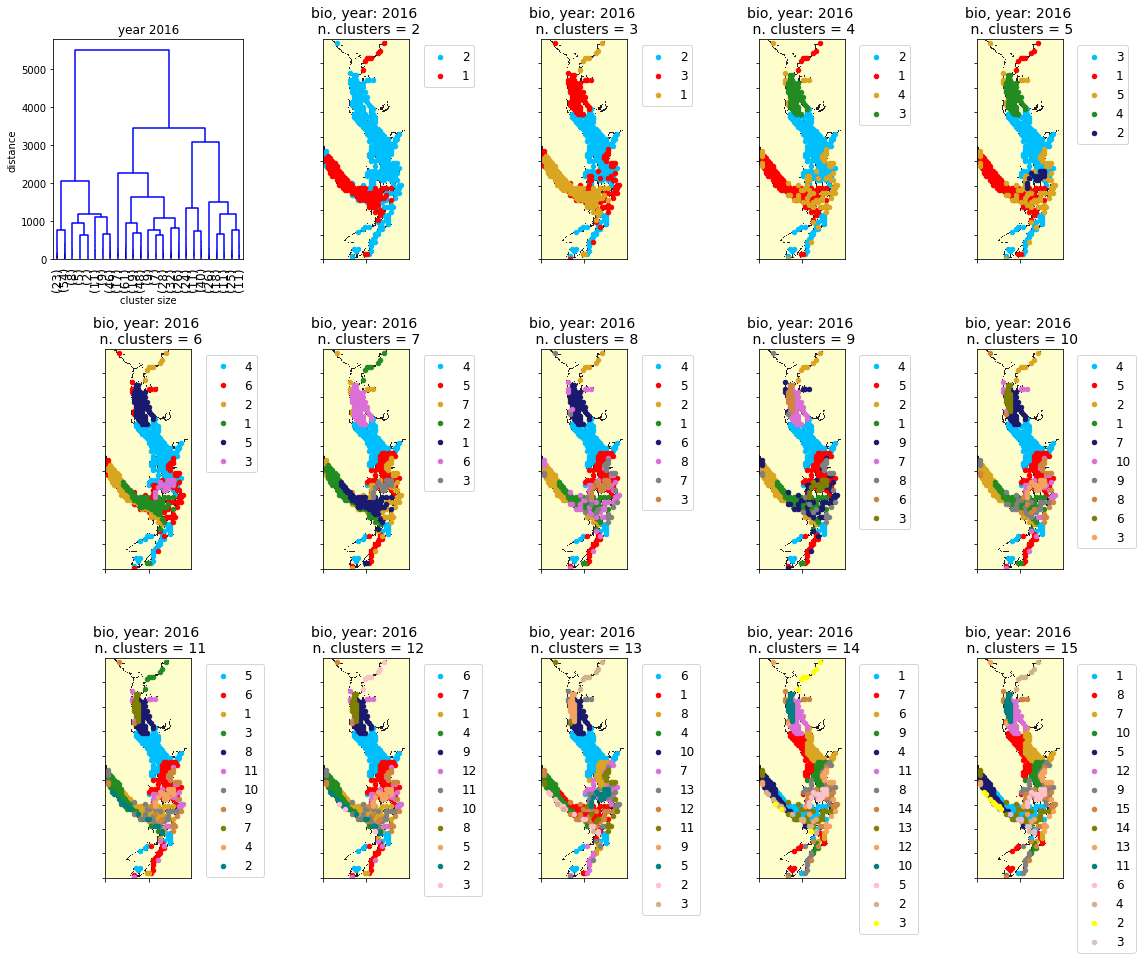

In [17]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/bio_linkmat_2016.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2016','bio',2)
vp.clusters(axs[0,2],'2016','bio',3)
vp.clusters(axs[0,3],'2016','bio',4)
vp.clusters(axs[0,4],'2016','bio',5)

vp.clusters(axs[1,0],'2016','bio',6)
vp.clusters(axs[1,1],'2016','bio',7)
vp.clusters(axs[1,2],'2016','bio',8)
vp.clusters(axs[1,3],'2016','bio',9)
vp.clusters(axs[1,4],'2016','bio',10)

vp.clusters(axs[2,0],'2016','bio',11)
vp.clusters(axs[2,1],'2016','bio',12)
vp.clusters(axs[2,2],'2016','bio',13)
vp.clusters(axs[2,3],'2016','bio',14)
vp.clusters(axs[2,4],'2016','bio',15)

plt.tight_layout()



#### 

In [18]:
cl_2013 = pickle.load(open('./pkls/bio_clustmat_2013.pkl', 'rb'))
cl_2014 = pickle.load(open('./pkls/bio_clustmat_2014.pkl', 'rb'))
cl_2015 = pickle.load(open('./pkls/bio_clustmat_2015.pkl', 'rb'))
cl_2016 = pickle.load(open('./pkls/bio_clustmat_2016.pkl', 'rb'))
sig_2013 = pickle.load(open('./pkls/bio_datamat_2013.pkl', 'rb'))
sig_2014 = pickle.load(open('./pkls/bio_datamat_2014.pkl', 'rb'))
sig_2015 = pickle.load(open('./pkls/bio_datamat_2015.pkl', 'rb'))
sig_2016 = pickle.load(open('./pkls/bio_datamat_2016.pkl', 'rb'))


## visualize original clusterings by size and do manual relabeling

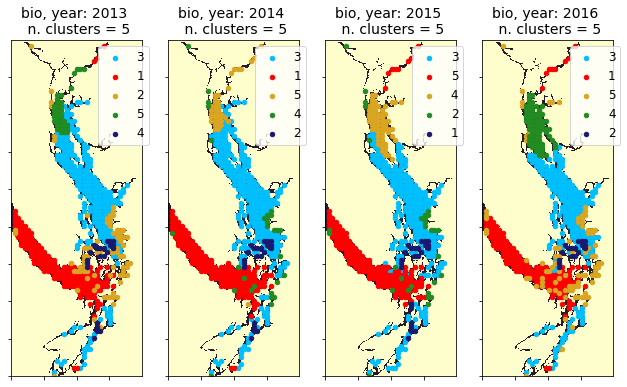

In [19]:
fact = 0.6
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters(axs[0],'2013','bio',5)
vp.clusters(axs[1],'2014','bio',5)
vp.clusters(axs[2],'2015','bio',5)
vp.clusters(axs[3],'2016','bio',5)

In [35]:


var = 'bio'
year = 2013
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2013_reass = np.zeros_like(cl_this)
cldes_2013_reass[cl_this == 1] = 5
cldes_2013_reass[cl_this == 2] = 2
cldes_2013_reass[cl_this == 3] = 3
cldes_2013_reass[cl_this == 4] = 1
cldes_2013_reass[cl_this == 5] = 4

year = 2014
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2014_reass = np.zeros_like(cl_this)
cldes_2014_reass[cl_this == 1] = 5
cldes_2014_reass[cl_this == 2] = 1
cldes_2014_reass[cl_this == 3] = 3
cldes_2014_reass[cl_this == 4] = 2
cldes_2014_reass[cl_this == 5] = 4

year = 2015
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2015_reass = np.zeros_like(cl_this)
cldes_2015_reass[cl_this == 1] = 1
cldes_2015_reass[cl_this == 2] = 2
cldes_2015_reass[cl_this == 3] = 3
cldes_2015_reass[cl_this == 4] = 4
cldes_2015_reass[cl_this == 5] = 5

year = 2016
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2016_reass = np.zeros_like(cl_this)
cldes_2016_reass[cl_this == 1] = 5
cldes_2016_reass[cl_this == 2] = 1
cldes_2016_reass[cl_this == 3] = 3
cldes_2016_reass[cl_this == 4] = 4
cldes_2016_reass[cl_this == 5] = 2





## chceck that reassigning worked

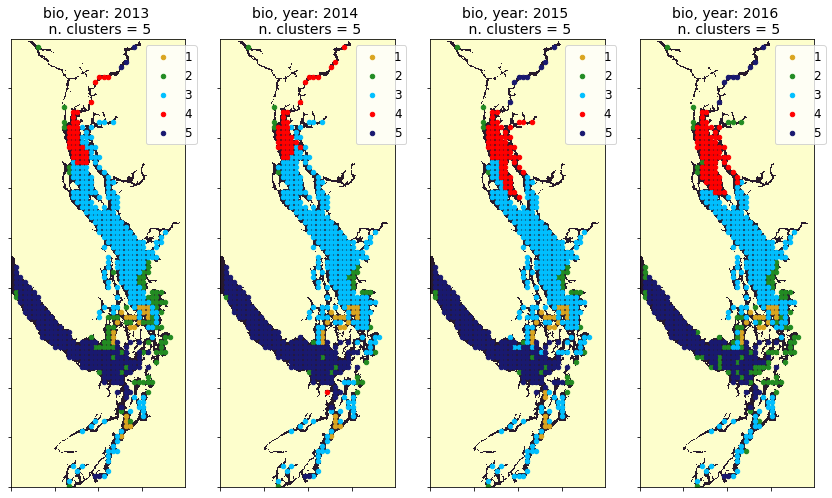

In [36]:
colors = ['white',
          'goldenrod',
          'forestgreen',
          'deepskyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']
    
reload(vp)
fact = 0.8
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters_basic(axs[0],'2013','bio',5,cldes_2013_reass, colors)
vp.clusters_basic(axs[1],'2014','bio',5,cldes_2014_reass, colors)
vp.clusters_basic(axs[2],'2015','bio',5,cldes_2015_reass, colors)
vp.clusters_basic(axs[3],'2016','bio',5,cldes_2016_reass, colors)

In [37]:
pickle.dump(cldes_2013_reass, open('./pkls/BIO_clno_5_2013_reass.pkl', 'wb'))
pickle.dump(cldes_2014_reass, open('./pkls/BIO_clno_5_2014_reass.pkl', 'wb'))
pickle.dump(cldes_2015_reass, open('./pkls/BIO_clno_5_2015_reass.pkl', 'wb'))
pickle.dump(cldes_2016_reass, open('./pkls/BIO_clno_5_2016_reass.pkl', 'wb'))

In [38]:
def cluster_patterns_mean_BIO(orig_data,cluster_des,cluster_no,noday):
    import numpy as np
    
    '''For a given data matrix (S stations X 365 daily signals), list of clusters designation (S stations), 
    and specific cluster, return an C_S x 365 matrix of the C_S annual signals in that cluster
    for the C_S stations in the cluster'''
    #which stations are in the cluster we are looking for?
    where_cluster = np.where(cluster_des == cluster_no)
    where_cluster = np.squeeze(where_cluster)
    #print(where_cluster.shape)
    #print(where_cluster.size)

    
    no_stns_in_cluster = where_cluster.size
    if no_stns_in_cluster == 1:
        this_stn = np.squeeze(where_cluster)
        where_cluster = this_stn
        signalmat = orig_data[this_stn,:]
        mean_signal = signalmat
    else:    
    
        signalmat = np.zeros([no_stns_in_cluster,noday*3])

        for stn in range(0,no_stns_in_cluster):

            this_stn = where_cluster[stn]
            signalmat[stn,:] = orig_data[this_stn,:]
        mean_signal = np.nanmean(signalmat, axis = 0)
    return mean_signal

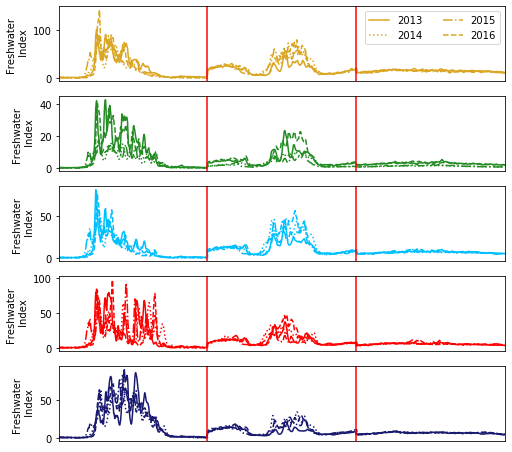

In [39]:
import cluster_fxn as cf

no_clust = 5

fact = 0.8
fig, axs = plt.subplots(5,1,figsize=(10*fact,10*fact))

#blues
linestyl = ['-',':','-.','--']
sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
labs = ['2013','2014','2015','2016']

clustdes = [1,1,1,1]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    axs[0].plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[1],\
                linestyle = linestyl[i], label = labs[i])
#axs[0].set_xlim([0,365])
axs[0].legend(loc = 'best', ncol = 2)

clustdes = [2,2,2,2]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    axs[1].plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[2],\
                linestyle = linestyl[i], label = labs[i])
#axs[1].set_xlim([0,365])

clustdes = [3,3,3,3]

for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    axs[2].plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[3],\
                linestyle = linestyl[i], label = labs[i])
#axs[2].set_xlim([0,365])

clustdes = [4,4,4,4]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    axs[3].plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[4],\
                linestyle = linestyl[i], label = labs[i])
#axs[3].set_xlim([0,365])

clustdes = [5,5,5,5]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    axs[4].plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[5],\
                linestyle = linestyl[i], label = labs[i])
#axs[4].set_xlim([0,365])

for i in range(0,5):
    #axs[i].set_ylim([0,125])
    axs[i].set_ylabel('Freshwater \n Index')
    axs[i].set_xticks([])
    axs[i].set_xlim([0,365*3])
    axs[i].axvline(x=365,color = 'r')
    axs[i].axvline(x=365*2,color = 'r')
# w = axs[4].set_xticks(np.arange(0,390,30))
# w = axs[4].set_xlabel('days of year')

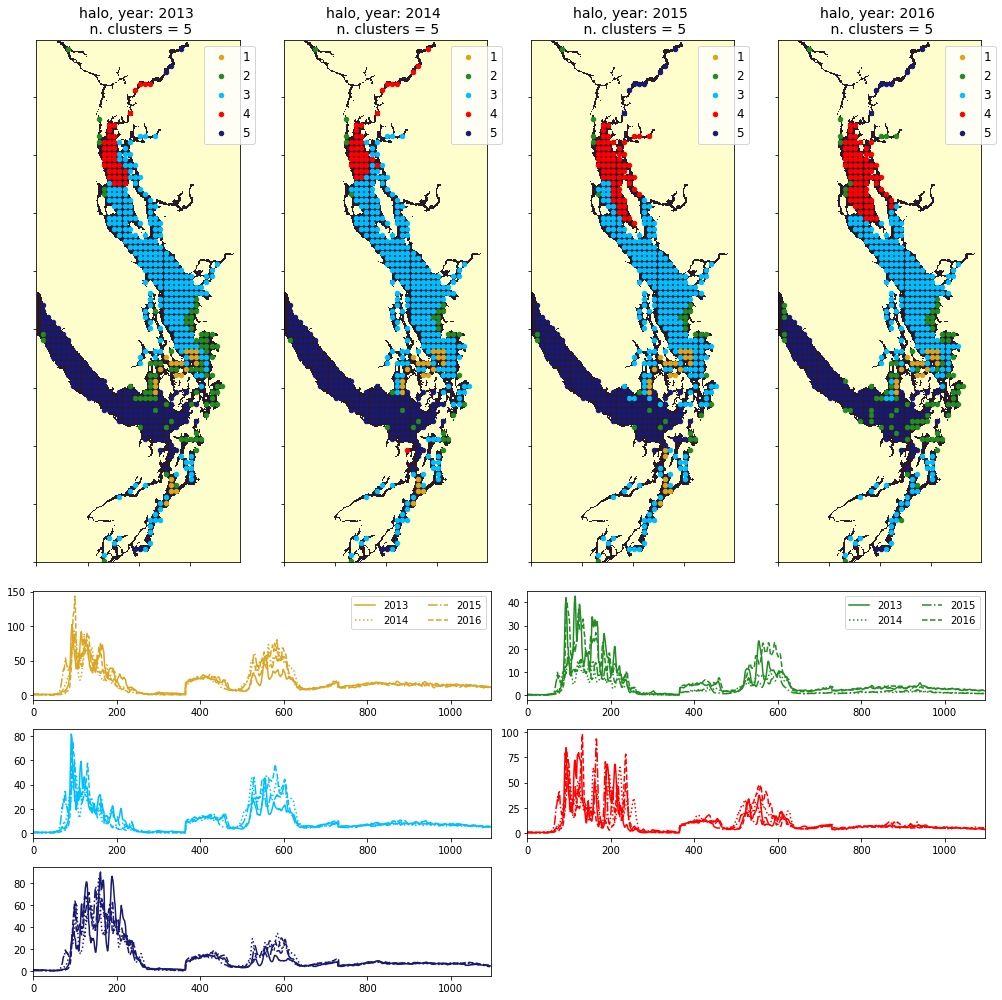

In [41]:
linestyl = ['-',':','-.','--']
sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
labs = ['2013','2014','2015','2016']



fact = 2
fig = plt.figure(figsize=(7*fact, 7*fact))

ax1 = plt.subplot2grid((7,4), (0,0), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2013','halo',5,cldes_2013_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,1), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2014','halo',5,cldes_2014_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,2), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2015','halo',5,cldes_2015_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,3), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2016','halo',5,cldes_2016_reass, colors)

ax1 = plt.subplot2grid((7,4), (4,0), colspan=2, rowspan=1)
clustdes = [1,1,1,1]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[1],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365*3])
#ax1.set_ylim([0,125])
ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (4,2), colspan=2, rowspan=1) 
clustdes = [2,2,2,2]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[2],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365*3])

ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (5,0), colspan=2, rowspan=1) 
clustdes = [3,3,3,3]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[3],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365*3])


ax1 = plt.subplot2grid((7,4), (5,2), colspan=2, rowspan=1) 
clustdes = [4,4,4,4]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[4],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365*3])
#ax1.set_ylim([0,125])

ax1 = plt.subplot2grid((7,4), (6,0), colspan=2, rowspan=1) 
clustdes = [5,5,5,5]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = cluster_patterns_mean_BIO(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i]*3,1),np.squeeze(tmean), color = colors[5],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365*3])
#ax1.set_ylim([0,125])
# ax1 = plt.subplot2grid((7,4), (6,2), colspan=2, rowspan=1) 
# ax1.set_xticks([])
# ax1.set_yticks([])

plt.tight_layout()




